# Import Library and Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflowjs as tfjs # For TFJS conversion
import time # To measure execution time
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [ ]:
path_prefix = '/content/drive/MyDrive/'
train_file_path = os.path.join(path_prefix, 'Laskar AI/train.xlsx')
val_file_path = os.path.join(path_prefix, 'Laskar AI/val.xlsx')
test_file_path = os.path.join(path_prefix, 'Laskar AI/test.xlsx')

In [7]:
train_df = pd.read_excel(train_file_path)
val_df = pd.read_excel(val_file_path)
test_df = pd.read_excel(test_file_path)
print("Data loaded successfully:")
print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTrain Head:")
train_df.head()

Data loaded successfully:
Train data shape: (1200, 2)
Validation data shape: (150, 2)
Test data shape: (150, 2)

Train Head:


,Keluhan,Label Emosi
0,saya termasuk orang yang berpenghasilan rendah...,2
1,sering banjir jalan sudah rusak semua tolong b...,2
2,pju padam kembali semalam setelah beberapa har...,2
3,sudah masuk login ke klampid tetapi tunggu ver...,2
4,rumah tidak layak huni alamat wonocolo utara 5...,2


# BERT Tokenizer & Model Initialization

In [8]:
MODEL_NAME = 'indobenchmark/indobert-lite-large-p1'
print(f"Loading BERT Tokenizer: {MODEL_NAME}")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
print(f"Loading TF BERT Model: {MODEL_NAME} (this may take a moment)")
bert_model = TFBertModel.from_pretrained(MODEL_NAME)
print("BERT Tokenizer and Model loaded.")

Loading BERT Tokenizer: indobenchmark/indobert-large-p1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Loading TF BERT Model: indobenchmark/indobert-large-p1 (this may take a moment)


tf_model.h5:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-large-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-large-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BERT Tokenizer and Model loaded.


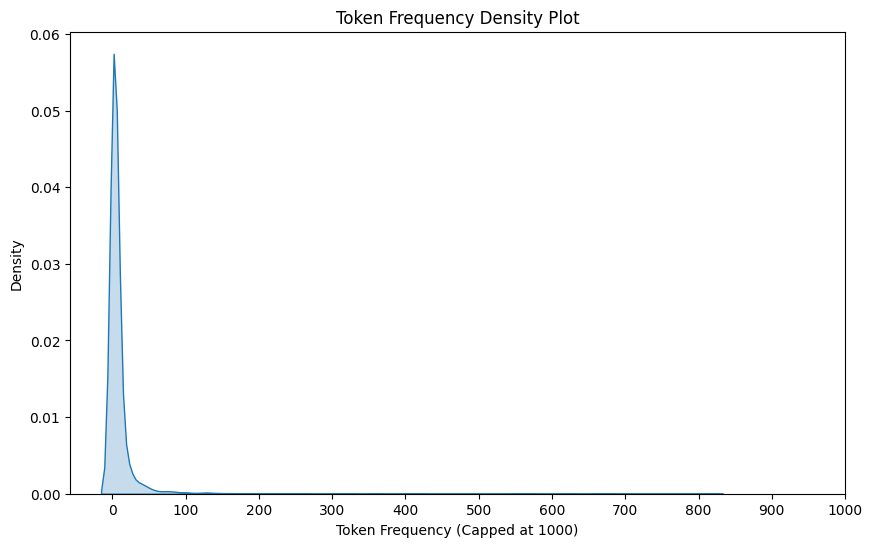

In [9]:
token_counts = {}
if 'Keluhan' in train_df.columns and not train_df.empty:
    for text in train_df['Keluhan']:
        tokens = tokenizer.tokenize(str(text)) # Ensure text is string
        for token in tokens:
            token_counts[token] = token_counts.get(token, 0) + 1
    token_counts_filtered = {k: v for k, v in token_counts.items() if v <= 1000} # Original cap

    # Plot token frequency as density plot
    if token_counts_filtered: # Only plot if there are tokens
        plt.figure(figsize=(10, 6))
        sns.kdeplot(list(token_counts_filtered.values()), fill=True)
        plt.xlabel('Token Frequency (Capped at 1000)')
        plt.ylabel('Density')
        plt.xticks(np.arange(0, 1001, 100))
        plt.title('Token Frequency Density Plot')
        plt.show()
    else:
        print("No tokens found for frequency analysis or all tokens filtered out.")
else:
    print("'Keluhan' column not found in train_df or train_df is empty. Skipping token frequency analysis.")


In [10]:
MAX_LENGTH = 128 # Max sequence length for BERT

def embed_tf(data_series, batch_size_embed=16): # Added batching for embedding
    if isinstance(data_series, pd.Series):
        data_list = data_series.tolist()
    elif isinstance(data_series, list):
        data_list = data_series
    else:
        raise TypeError("Input 'data_series' must be a pandas Series or a list of strings.")

    # Ensure all items in data are strings
    data_list = [str(item) for item in data_list]

    all_embeddings = []
    num_samples = len(data_list)

    print(f"Starting embedding for {num_samples} samples with batch size {batch_size_embed}...")
    for i in range(0, num_samples, batch_size_embed):
        batch_texts = data_list[i:i+batch_size_embed]
        encoded_batch = tokenizer.batch_encode_plus(batch_texts,
                                                    add_special_tokens=True,
                                                    max_length=MAX_LENGTH,
                                                    padding='max_length',
                                                    return_attention_mask=True,
                                                    truncation=True,
                                                    return_tensors='tf')

        input_ids = encoded_batch['input_ids']
        attention_masks = encoded_batch['attention_mask']

        outputs = bert_model(input_ids, attention_mask=attention_masks)
        last_hidden_states = outputs.last_hidden_state
        all_embeddings.append(last_hidden_states.numpy()) # Convert to numpy and append
        if (i // batch_size_embed + 1) % 10 == 0 : # Print progress every 10 batches
             print(f"  Embedded batch {i // batch_size_embed + 1}/{(num_samples + batch_size_embed -1) // batch_size_embed}")

    print("Embedding complete.")
    return tf.convert_to_tensor(np.concatenate(all_embeddings, axis=0), dtype=tf.float32)


In [11]:
if not train_df.empty and not val_df.empty and not test_df.empty:
    print("Preparing data and generating embeddings...")
    start_time_embed = time.time()

    train_labels_series, train_inputs_series = train_df['Label Emosi'], train_df['Keluhan']
    validation_labels_series, validation_inputs_series = val_df['Label Emosi'], val_df['Keluhan']
    test_labels_series, test_inputs_series = test_df['Label Emosi'], test_df['Keluhan']

    # Generate embeddings
    print("Generating train embeddings...")
    train_last_hidden_states = embed_tf(train_inputs_series)
    print("Generating validation embeddings...")
    validation_last_hidden_states = embed_tf(validation_inputs_series)
    print("Generating test embeddings...")
    test_last_hidden_states = embed_tf(test_inputs_series)

    end_time_embed = time.time()
    print(f"Embedding generation took {end_time_embed - start_time_embed:.2f} seconds.")

    # Convert labels to tensors
    train_label_tf = tf.convert_to_tensor(train_labels_series.values, dtype=tf.int64)
    validation_label_tf = tf.convert_to_tensor(validation_labels_series.values, dtype=tf.int64)
    test_label_tf = tf.convert_to_tensor(test_labels_series.values, dtype=tf.int64)

    train_embedding_dim = train_last_hidden_states.shape[2]
    num_classes = len(np.unique(train_labels_series.dropna())) # Ensure NaNs are handled if any
    print(f"Number of classes: {num_classes}")
    print(f"Embedding dimension: {train_embedding_dim}")


    # Create tf.data.Dataset
    BATCH_SIZE = 8 # Keep batch size consistent

    train_dataset = tf.data.Dataset.from_tensor_slices((train_last_hidden_states, train_label_tf))
    train_dataset = train_dataset.shuffle(buffer_size=len(train_last_hidden_states)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_last_hidden_states, validation_label_tf))
    validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_last_hidden_states, test_label_tf))
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    print("tf.data.Dataset created.")
    # Check a batch
    for features, labels in train_dataset.take(1):
        print("Sample batch - Features shape:", features.shape, "Labels shape:", labels.shape)
        break
else:
    print("One or more dataframes (train, val, test) are empty. Skipping data preparation.")
    # Set dummy values to prevent later errors if script continues for structure testing
    num_classes = 3
    train_embedding_dim = 1024 # Typical for BERT large


Preparing data and generating embeddings...
Generating train embeddings...
Starting embedding for 1200 samples with batch size 16...
  Embedded batch 10/75
  Embedded batch 20/75
  Embedded batch 30/75
  Embedded batch 40/75
  Embedded batch 50/75
  Embedded batch 60/75
  Embedded batch 70/75
Embedding complete.
Generating validation embeddings...
Starting embedding for 150 samples with batch size 16...
  Embedded batch 10/10
Embedding complete.
Generating test embeddings...
Starting embedding for 150 samples with batch size 16...
  Embedded batch 10/10
Embedding complete.
Embedding generation took 2981.39 seconds.
Number of classes: 3
Embedding dimension: 1024
tf.data.Dataset created.
Sample batch - Features shape: (8, 128, 1024) Labels shape: (8,)


In [12]:
def create_lstm_classifier(embedding_dim, hidden_dim, num_lstm_layers, output_dim, sequence_length=MAX_LENGTH):
    inputs = Input(shape=(sequence_length, embedding_dim), name="bert_embeddings")
    x = inputs
    for i in range(num_lstm_layers):
        return_sequences = True if i < num_lstm_layers - 1 else False
        x = LSTM(hidden_dim, return_sequences=return_sequences, name=f"lstm_layer_{i+1}")(x)
    x = Dropout(0.15, name="dropout_lstm_out")(x) # Original dropout rate
    x = Dense(128, activation='relu', name="dense_layer")(x)
    outputs = Dense(output_dim, activation='softmax', name="output_layer")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Function to get predictions and probabilities
def predict_tf_keras(model, dataset):
    all_probs_list = []
    all_preds_list = []
    for inputs_batch, _ in dataset: # Assuming dataset yields (features, labels)
        probs = model.predict_on_batch(inputs_batch) # Use predict_on_batch for tf.data.Dataset iter
        preds = np.argmax(probs, axis=1)
        all_probs_list.append(probs)
        all_preds_list.append(preds)

    all_probs = np.concatenate(all_probs_list, axis=0)
    all_preds = np.concatenate(all_preds_list, axis=0)
    return np.array(all_preds), np.array(all_probs)

In [18]:
hidden_dims_list = [5, 10, 15]  # Original: [5, 10, 15]
learning_rates_list = [0.001] # Original: [0.001, 0.01]
optimizers_map = {'Adam': Adam, 'Adamax': Adamax, 'AdamW': AdamW} # Original included AdamW
num_lstm_layers_options = [2, 3, 5] # Original: [2, 3, 4, 5]
epochs_options = [20] # Reduced from [100] for quick demo. Set to e.g. 20-50 for real run.
PATIENCE_EARLY_STOPPING = 10 # Original was 10 for grid search

grid_search_results_list = []
best_val_accuracy_grid = 0
best_params_grid = {}

print("\n--- Hyperparameter Search Configuration ---")
print(f"Hidden Dims: {hidden_dims_list}")
print(f"Learning Rates: {learning_rates_list}")
print(f"Optimizers: {list(optimizers_map.keys())}")
print(f"Num LSTM Layers: {num_lstm_layers_options}")
print(f"Epochs per run: {epochs_options}")
print(f"Early Stopping Patience: {PATIENCE_EARLY_STOPPING}")


--- Hyperparameter Search Configuration ---
Hidden Dims: [5, 10, 15]
Learning Rates: [0.001]
Optimizers: ['Adam', 'Adamax', 'AdamW']
Num LSTM Layers: [2, 3, 5]
Epochs per run: [20]
Early Stopping Patience: 10


In [19]:
if not train_df.empty and not val_df.empty and not test_df.empty : #Only run if data is loaded
    print("\n--- Starting Hyperparameter Search ---")
    total_combinations = len(hidden_dims_list) * len(learning_rates_list) * len(optimizers_map) * len(num_lstm_layers_options) * len(epochs_options)
    current_combination = 0
    search_start_time = time.time()

    for hidden_dim_val in hidden_dims_list:
        for lr_val in learning_rates_list:
            for optimizer_name_val, optimizer_class_val in optimizers_map.items():
                for num_layer_val in num_lstm_layers_options:
                    for num_epochs_val in epochs_options:
                        current_combination += 1
                        print(f"\nGrid Search Combination {current_combination}/{total_combinations}")
                        print(f"Testing: HD={hidden_dim_val}, LR={lr_val}, Opt={optimizer_name_val}, Layers={num_layer_val}, Epochs={num_epochs_val}")

                        model_grid = create_lstm_classifier(train_embedding_dim, hidden_dim_val, num_layer_val, num_classes)
                        optimizer_instance_grid = optimizer_class_val(learning_rate=lr_val)
                        model_grid.compile(optimizer=optimizer_instance_grid,
                                      loss=SparseCategoricalCrossentropy(from_logits=False),
                                      metrics=['accuracy'])

                        early_stopping_grid = EarlyStopping(monitor='val_accuracy',
                                                            patience=PATIENCE_EARLY_STOPPING,
                                                            restore_best_weights=True,
                                                            mode='max',
                                                            verbose=1)

                        history_grid = model_grid.fit(train_dataset,
                                            epochs=num_epochs_val,
                                            validation_data=validation_dataset,
                                            callbacks=[early_stopping_grid],
                                            verbose=1) # Show progress for each epoch

                        # Evaluate on validation set (using best weights due to restore_best_weights)
                        val_loss_grid, val_accuracy_grid = model_grid.evaluate(validation_dataset, verbose=0)

                        # Get true labels for validation
                        val_true_labels_grid = []
                        for _, labels_batch_grid in validation_dataset: # Re-iterate to get all labels
                            val_true_labels_grid.extend(labels_batch_grid.numpy())

                        val_preds_idx_grid, val_probs_grid = predict_tf_keras(model_grid, validation_dataset)

                        precision_grid = precision_score(val_true_labels_grid, val_preds_idx_grid, average='macro', zero_division=0)
                        recall_grid = recall_score(val_true_labels_grid, val_preds_idx_grid, average='macro', zero_division=0)
                        f1_val_grid = f1_score(val_true_labels_grid, val_preds_idx_grid, average='macro', zero_division=0)

                        roc_auc_grid = 0.0
                        try:
                            if val_probs_grid.shape[1] >= num_classes:
                                roc_auc_grid = roc_auc_score(val_true_labels_grid, val_probs_grid, multi_class='ovr', average='macro', labels=np.arange(num_classes))
                            else: # Handle cases where not all classes are predicted, create full prob array
                                full_val_probs_grid = np.zeros((len(val_probs_grid), num_classes))
                                for i_sample in range(len(val_preds_idx_grid)):
                                    pred_class = val_preds_idx_grid[i_sample]
                                    # Ensure all probabilities for this sample sum up to 1 for the predicted classes
                                    # This part is tricky if val_probs_grid doesn't reflect all classes
                                    # A simpler approach for partial predictions might be needed if direct mapping is hard
                                    # For now, just assign the predicted class probability if available
                                    if val_probs_grid.shape[1] > pred_class :
                                        full_val_probs_grid[i_sample, pred_class] = val_probs_grid[i_sample, pred_class] if val_probs_grid.shape[1] > pred_class else 1.0 # Fallback if prob missing for pred_class
                                    else : # If predicted class index is out of bounds of prob array
                                        full_val_probs_grid[i_sample, pred_class] = 1.0 # Simplified
                                roc_auc_grid = roc_auc_score(val_true_labels_grid, full_val_probs_grid, multi_class='ovr', average='macro', labels=np.arange(num_classes))
                        except ValueError as e_roc:
                            print(f"ROC AUC calculation error during grid search: {e_roc}. Setting ROC AUC to 0.")

                        print(f"  Validation Accuracy: {val_accuracy_grid*100:.2f}%")
                        print(f"  Precision: {precision_grid:.4f}, Recall: {recall_grid:.4f}, F1: {f1_val_grid:.4f}, ROC AUC: {roc_auc_grid:.4f}")

                        stop_epoch_grid = early_stopping_grid.stopped_epoch
                        if stop_epoch_grid > 0: # Keras reports 0-indexed epoch where stopping occurred
                            actual_epochs_run_grid = stop_epoch_grid + 1
                        else: # Not stopped early, ran full epochs
                            actual_epochs_run_grid = num_epochs_val

                        current_params = {
                            'Hidden_Dim': hidden_dim_val, 'LR': lr_val, 'Optimizer': optimizer_name_val,
                            'Num_LSTM_Layers': num_layer_val, 'Batch_Size': BATCH_SIZE,
                            'Configured_Epochs': num_epochs_val, 'Actual_Epochs_Run': actual_epochs_run_grid,
                            'Validation_Accuracy': val_accuracy_grid, 'Precision': precision_grid,
                            'Recall': recall_grid, 'F1_Score': f1_val_grid, 'ROC_AUC': roc_auc_grid
                        }
                        grid_search_results_list.append(current_params)

                        if val_accuracy_grid > best_val_accuracy_grid:
                            best_val_accuracy_grid = val_accuracy_grid
                            best_params_grid = current_params.copy() # Store a copy
                            # Optionally save the best model during grid search
                            # model_grid.save('best_grid_search_model.keras')
    search_end_time = time.time()
    print(f"\nHyperparameter search finished in {(search_end_time - search_start_time)/60:.2f} minutes.")
else:
    print("Skipping hyperparameter search due to empty dataframes.")


--- Starting Hyperparameter Search ---

Grid Search Combination 1/27
Testing: HD=5, LR=0.001, Opt=Adam, Layers=2, Epochs=20
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.5918 - loss: 0.9396 - val_accuracy: 0.6400 - val_loss: 0.8199
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.6815 - loss: 0.6988 - val_accuracy: 0.6800 - val_loss: 0.7506
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.7446 - loss: 0.5817 - val_accuracy: 0.7600 - val_loss: 0.6581
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.7896 - loss: 0.5397 - val_accuracy: 0.7733 - val_loss: 0.5880
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8272 - loss: 0.4339 - val_accuracy: 0.7600 - val_loss: 0.6260
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.8640 - loss: 0.3885 - val_accuracy: 0.7467 - val_loss: 0.6498
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9044 - loss: 0.3085 - val_a

In [20]:
if grid_search_results_list:
    results_df_grid = pd.DataFrame(grid_search_results_list)
    print("\n--- Grid Search Results Summary ---")
    print(results_df_grid.sort_values(by='Validation_Accuracy', ascending=False).head())
    results_df_grid.to_excel('grid_search_results_indobert_lstm_tf.xlsx', index=False)
    print("\nFull grid search results saved to 'grid_search_results_indobert_lstm_tf.xlsx'")

    print(f"\nBest Validation Accuracy from Grid Search: {best_val_accuracy_grid*100:.2f}%")
    print("Best Parameters from Grid Search:")
    for key, val in best_params_grid.items():
        print(f"  {key}: {val}")
else:
    print("No grid search results to display.")
    # Use default parameters if grid search didn't run or found nothing
    best_params_grid = {
        'Hidden_Dim': 15, 'LR': 0.001, 'Optimizer': 'Adam',
        'Num_LSTM_Layers': 2, 'Actual_Epochs_Run': 10 # Default epochs if not determined
    }
    print("Using default parameters for final model training.")


--- Grid Search Results Summary ---
    Hidden_Dim     LR Optimizer  Num_LSTM_Layers  Batch_Size  \
23          15  0.001    Adamax                5           8   
12          10  0.001    Adamax                2           8   
6            5  0.001     AdamW                2           8   
16          10  0.001     AdamW                3           8   
25          15  0.001     AdamW                3           8   

    Configured_Epochs  Actual_Epochs_Run  Validation_Accuracy  Precision  \
23                 20                 20             0.813333   0.794062   
12                 20                 20             0.793333   0.788080   
6                  20                 20             0.793333   0.748967   
16                 20                 14             0.793333   0.772109   
25                 20                 17             0.793333   0.773680   

      Recall  F1_Score   ROC_AUC  
23  0.778352  0.785720  0.884517  
12  0.727375  0.751204  0.872792  
6   0.758604  0.

In [21]:
print("\n--- Starting Final Model Training ---")
final_hidden_dim = best_params_grid.get('Hidden_Dim', 15)
final_lr = best_params_grid.get('LR', 0.001)
final_optimizer_name = best_params_grid.get('Optimizer', 'Adam')
final_num_layers = best_params_grid.get('Num_LSTM_Layers', 2)
# Train for a fixed number of epochs or epochs found by early stopping for the best model
# Let's use a fixed number for this final training, e.g., 20, or the 'Actual_Epochs_Run' from best_params_grid.
FINAL_MODEL_EPOCHS = best_params_grid.get('Actual_Epochs_Run', 15) # Use actual or a default
FINAL_MODEL_PATIENCE = 5 # Patience for the final model training early stopping

if not train_df.empty and not val_df.empty and not test_df.empty:
    final_model = create_lstm_classifier(train_embedding_dim, final_hidden_dim, final_num_layers, num_classes)
    final_optimizer_instance = optimizers_map[final_optimizer_name](learning_rate=final_lr)
    final_model.compile(optimizer=final_optimizer_instance,
                        loss=SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

    print("\nFinal Model Summary:")
    final_model.summary()

    final_early_stopping = EarlyStopping(monitor='val_accuracy',
                                         patience=FINAL_MODEL_PATIENCE,
                                         restore_best_weights=True,
                                         mode='max',
                                         verbose=1)

    print(f"Training final model with: HD={final_hidden_dim}, LR={final_lr}, Opt={final_optimizer_name}, Layers={final_num_layers}, Max Epochs={FINAL_MODEL_EPOCHS}")
    final_model_start_time = time.time()
    history_final_model = final_model.fit(train_dataset,
                                          epochs=FINAL_MODEL_EPOCHS,
                                          validation_data=validation_dataset,
                                          callbacks=[final_early_stopping],
                                          verbose=1)
    final_model_end_time = time.time()
    print(f"Final model training took {(final_model_end_time - final_model_start_time)/60:.2f} minutes.")
else:
    print("Skipping final model training due to empty dataframes.")
    final_model = None # Ensure final_model is None if not trained


--- Starting Final Model Training ---

Final Model Summary:


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bert_embeddings (InputLayer)    │ (None, 128, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 128, 15)        │        62,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 128, 15)        │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_3 (LSTM)             │ (None, 128, 15)        │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_4 (LSTM)             │ (None, 128, 15)        │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_5 (LSTM)             │ (None, 15)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_out (Dropout)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,275 (282.32 KB)

 Trainable params: 72,275 (282.32 KB)

 Non-trainable params: 0 (0.00 B)

Training final model with: HD=15, LR=0.001, Opt=Adamax, Layers=5, Max Epochs=20
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.6111 - loss: 0.9582 - val_accuracy: 0.5667 - val_loss: 0.8839
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 217ms/step - accuracy: 0.6486 - loss: 0.7862 - val_accuracy: 0.5667 - val_loss: 0.8044
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.6478 - loss: 0.7080 - val_accuracy: 0.7000 - val_loss: 0.7692
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 217ms/step - accuracy: 0.7810 - loss: 0.6215 - val_accuracy: 0.7067 - val_loss: 0.7380
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.7777 - loss: 0.5518 - val_accuracy: 0.7267 - val_loss: 0.7133
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 218ms/step - accuracy: 0.8220 - loss: 0.4644 - val_accuracy: 0.7400 - val_loss: 0.7520
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.8604 - loss: 0.3988 - val_accuracy: 0.7400 - val_loss: 0.7596
Epo


--- Plotting Training History for Final Model ---


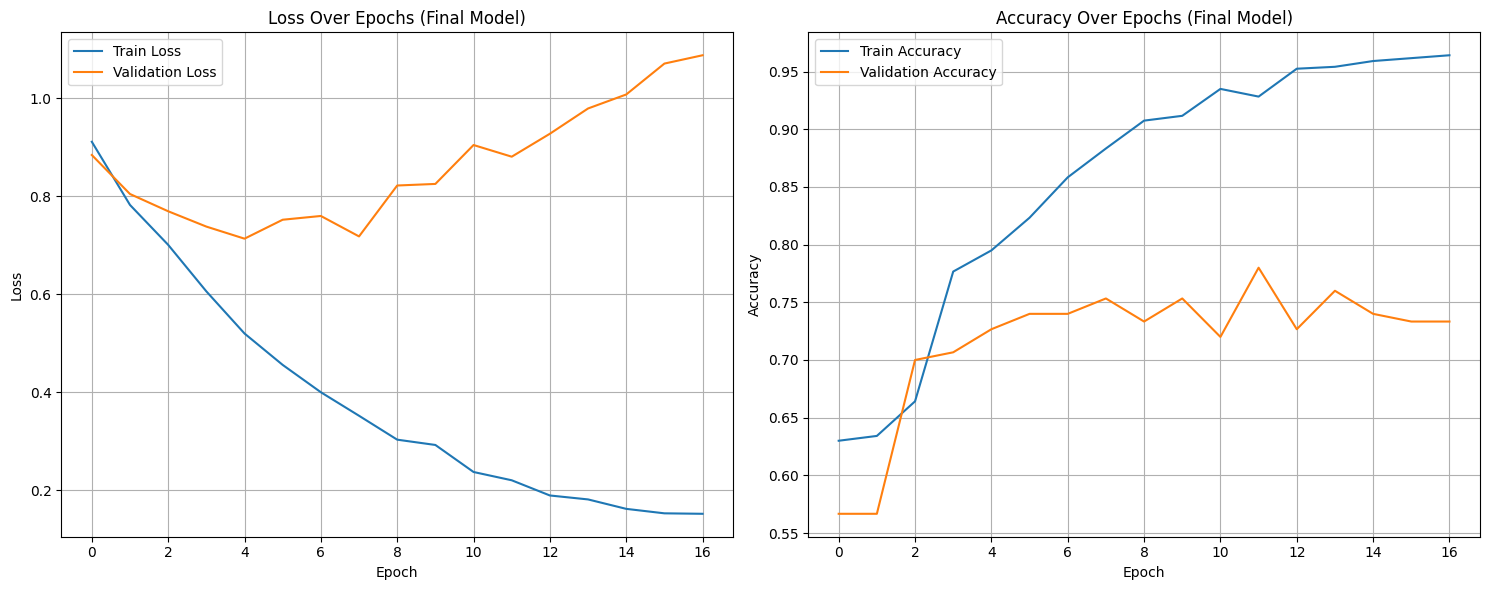

In [22]:
if final_model and hasattr(history_final_model, 'history'):
    print("\n--- Plotting Training History for Final Model ---")
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_final_model.history['loss'], label='Train Loss')
    plt.plot(history_final_model.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs (Final Model)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history_final_model.history['accuracy'], label='Train Accuracy')
    plt.plot(history_final_model.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs (Final Model)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No history to plot for final model.")

In [23]:
if final_model and not test_df.empty:
    print("\n--- Evaluating Final Model on Test Set ---")
    test_loss_final, test_accuracy_eval_final = final_model.evaluate(test_dataset, verbose=0)
    print(f"Test Loss (from model.evaluate): {test_loss_final:.4f}")
    print(f"Test Accuracy (from model.evaluate): {test_accuracy_eval_final*100:.2f}%")

    test_true_labels_final = []
    for _, labels_batch_final in test_dataset: # Re-iterate to get all labels
        test_true_labels_final.extend(labels_batch_final.numpy())

    test_preds_idx_final, test_probs_final = predict_tf_keras(final_model, test_dataset)

    accuracy_test_final = accuracy_score(test_true_labels_final, test_preds_idx_final)
    precision_test_final = precision_score(test_true_labels_final, test_preds_idx_final, average='macro', zero_division=0)
    recall_test_final = recall_score(test_true_labels_final, test_preds_idx_final, average='macro', zero_division=0)
    f1_test_final = f1_score(test_true_labels_final, test_preds_idx_final, average='macro', zero_division=0)

    roc_auc_test_final = 0.0
    try:
        if test_probs_final.shape[1] >= num_classes:
            roc_auc_test_final = roc_auc_score(test_true_labels_final, test_probs_final, multi_class='ovr', average='macro', labels=np.arange(num_classes))
        else:
            full_test_probs_final = np.zeros((len(test_probs_final), num_classes))
            # Simplified assignment - assumes model.predict gives probabilities for predicted classes.
            for i_sample in range(len(test_preds_idx_final)):
                pred_class = test_preds_idx_final[i_sample]
                if test_probs_final.shape[1] > pred_class:
                     full_test_probs_final[i_sample, pred_class] = test_probs_final[i_sample, pred_class]
                else: # fallback if predicted class index is out of bounds of probability array
                     full_test_probs_final[i_sample, pred_class] = 1.0 # Simplified
            roc_auc_test_final = roc_auc_score(test_true_labels_final, full_test_probs_final, multi_class='ovr', average='macro', labels=np.arange(num_classes))

    except ValueError as e_roc_test:
        print(f"Test ROC AUC calculation error: {e_roc_test}. Setting ROC AUC to 0.")

    print(f"\nCalculated Test Metrics:")
    print(f"  Accuracy: {accuracy_test_final*100:.2f}%")
    print(f"  Precision (Macro): {precision_test_final:.4f}")
    print(f"  Recall (Macro): {recall_test_final:.4f}")
    print(f"  F1-Score (Macro): {f1_test_final:.4f}")
    print(f"  ROC AUC (Macro OVR): {roc_auc_test_final:.4f}")
else:
    print("Final model not available or test data empty. Skipping test set evaluation.")


--- Evaluating Final Model on Test Set ---
Test Loss (from model.evaluate): 0.5922
Test Accuracy (from model.evaluate): 79.33%

Calculated Test Metrics:
  Accuracy: 79.33%
  Precision (Macro): 0.7301
  Recall (Macro): 0.8050
  F1-Score (Macro): 0.7609
  ROC AUC (Macro OVR): 0.9120



--- Plotting Confusion Matrix for Test Set ---


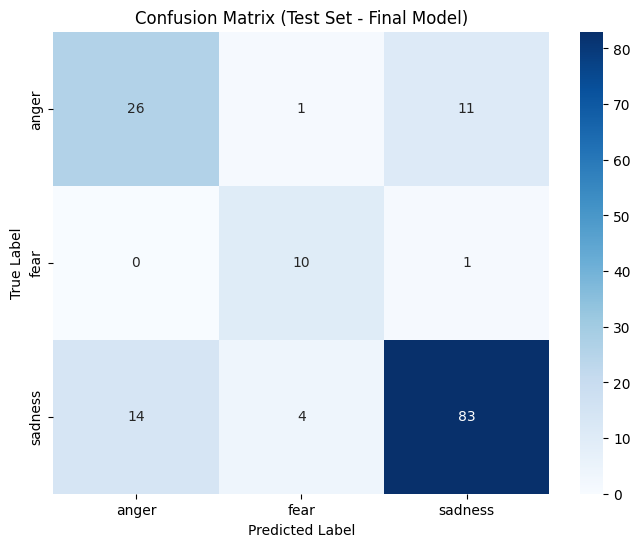

In [29]:
if final_model and not test_df.empty:
    print("\n--- Plotting Confusion Matrix for Test Set ---")
    conf_matrix_final = confusion_matrix(test_true_labels_final, test_preds_idx_final)

    # Define class names (adjust if your labels are different)
    # Assuming labels are 0, 1, 2, ...
    unique_labels_sorted = sorted(train_df['Label Emosi'].unique())
    class_names = [str(i) for i in unique_labels_sorted]
    class_names_map = {0: 'anger', 1: 'fear', 2: 'sadness'} # Adjust as per your data
    class_names = [class_names_map.get(i, str(i)) for i in unique_labels_sorted]


    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_final, annot=True, cmap='Blues', fmt='g',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set - Final Model)')
    plt.show()
else:
    print("Cannot plot confusion matrix: final model or test data not available.")

In [26]:
if final_model:
    print("\n--- Saving Final Model in Different Formats ---")
    save_dir = "/content/drive/MyDrive/Laskar AI/final_saved_models"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 1. TensorFlow SavedModel format
    saved_model_tf_path = os.path.join(save_dir, "indobert_lstm_savedmodel_tf")
    try:
        final_model.save(saved_model_tf_path) # Saves in TF format by default if path is a dir
        print(f"Model saved in TensorFlow SavedModel format at: {saved_model_tf_path}")
    except Exception as e:
        print(f"Error saving model in TensorFlow SavedModel format: {e}")

    # 2. Keras native format (.keras) - recommended over .h5
    keras_model_path = os.path.join(save_dir, "indobert_lstm_model.keras")
    try:
        final_model.save(keras_model_path)
        print(f"Model saved in Keras native (.keras) format at: {keras_model_path}")
    except Exception as e:
        print(f"Error saving model in Keras native (.keras) format: {e}")

    # 3. TensorFlow Lite (TFLite) format
    tflite_model_path = os.path.join(save_dir, "indobert_lstm_model.tflite")
    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        # Optional: Optimizations (start without for complex models like BERT)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model_content = converter.convert()
        with open(tflite_model_path, 'wb') as f:
            f.write(tflite_model_content)
        print(f"Model saved in TensorFlow Lite format at: {tflite_model_path}")
    except Exception as e:
        print(f"Error saving model in TensorFlow Lite format: {e}")
        print("Note: BERT-based models can be complex for TFLite.")

    # 4. TensorFlow.js (TFJS) format
    tfjs_model_path = os.path.join(save_dir, "indobert_lstm_tfjs")
    try:
        tfjs.converters.save_keras_model(final_model, tfjs_model_path)
        print(f"Model saved in TensorFlow.js format at: {tfjs_model_path}")
    except Exception as e:
        print(f"Error saving model in TensorFlow.js format: {e}")
        print("Ensure `tensorflowjs` is installed.")

    print("\n--- Model Saving Process Complete ---")
    print(f"Models are saved in the directory: '{save_dir}' (relative to Colab environment)")
    print("You can download this directory from Colab's file browser (left panel).")
else:
    print("Final model not available. Skipping model saving.")


--- Saving Final Model in Different Formats ---
Error saving model in TensorFlow SavedModel format: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/Laskar AI/final_saved_models/indobert_lstm_savedmodel_tf.
Model saved in Keras native (.keras) format at: /content/drive/MyDrive/Laskar AI/final_saved_models/indobert_lstm_model.keras
Saved artifact at '/tmp/tmp662xytah'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 1024), dtype=tf.float32, name='bert_embeddings')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140473135556624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140473135558352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14047

Model saved in TensorFlow Lite format at: /content/drive/MyDrive/Laskar AI/final_saved_models/indobert_lstm_model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
Model saved in TensorFlow.js format at: /content/drive/MyDrive/Laskar AI/final_saved_models/indobert_lstm_tfjs

--- Model Saving Process Complete ---
Models are saved in the directory: '/content/drive/MyDrive/Laskar AI/final_saved_models' (relative to Colab environment)
You can download this directory from Colab's file browser (left panel).


In [41]:
try:
    loaded_final_model = tf.keras.models.load_model('/content/drive/MyDrive/Laskar AI/final_saved_models/indobert_lstm_model.keras')
    print("Model berhasil dimuat dari folder (.keras format).")
except Exception as e:
    print(f"Gagal memuat model (.keras format) dari folder: {e}")
    loaded_final_model = None

active_model_for_inference = None
if 'loaded_final_model' in globals() and loaded_final_model is not None:
    active_model_for_inference = loaded_final_model
    print("Menggunakan 'loaded_final_model' untuk inferensi.")
elif 'final_model' in globals() and final_model is not None:
    active_model_for_inference = final_model
    print("Menggunakan 'final_model' (dari training) untuk inferensi.")


if active_model_for_inference: # Pastikan model (final_model atau loaded_final_model) sudah ada
    print("\n--- Setting up for Inference ---")

    # Definisikan pemetaan nama kelas (PENTING: SESUAIKAN DENGAN DATA ANDA)
    if 'train_df' in globals() and not train_df.empty and 'Label Emosi' in train_df.columns:
        unique_labels_from_data = sorted([int(label) for label in train_df['Label Emosi'].unique()])
        detected_num_classes = len(unique_labels_from_data)
        print(f"Label unik yang terdeteksi dari train_df: {unique_labels_from_data}")
        print(f"Jumlah kelas yang terdeteksi: {detected_num_classes}")
        actual_class_labels = ['anger', 'fear', 'sadness']

        if detected_num_classes != len(actual_class_labels):
            print(f"PERINGATAN: Jumlah kelas terdeteksi ({detected_num_classes}) berbeda dari "
                  f"jumlah `actual_class_labels` ({len(actual_class_labels)}).")
            print("Menggunakan pemetaan default berdasarkan indeks saja.")
            class_names_map_inference = {i: f"Label_{unique_labels_from_data[i]}" for i in range(detected_num_classes)}
        else:
            class_names_map_inference = {unique_labels_from_data[i]: actual_class_labels[i] for i in range(detected_num_classes)}

        print(f"Class Names Map for Inference: {class_names_map_inference}")
    else:
        print("train_df tidak tersedia atau tidak valid, menggunakan class_names_map default untuk inferensi.")
        # Fallback jika train_df tidak bisa digunakan untuk menentukan kelas
        actual_class_labels = ['anger (default)', 'fear (default)', 'sadness (default)']
        class_names_map_inference = {0: actual_class_labels[0], 1: actual_class_labels[1], 2: actual_class_labels[2]}
        print(f"Class Names Map for Inference (default): {class_names_map_inference}")


    def predict_emotion_from_text(text_input, tokenizer_inf, bert_embedding_model_inf, classification_model_inf, class_map_inf, max_len=MAX_LENGTH): # MAX_LENGTH harus terdefinisi global
        if not isinstance(text_input, str) or not text_input.strip():
            return "Input tidak valid", 0.0
        # print(f"\nInput teks: \"{text_input}\"") # Bisa di-uncomment jika ingin lebih verbose

        encoded_input = tokenizer_inf.encode_plus(
            text_input, add_special_tokens=True, max_length=max_len,
            padding='max_length', truncation=True, return_attention_mask=True, return_tensors='tf'
        )
        input_ids = encoded_input['input_ids']
        attention_mask = encoded_input['attention_mask']

        # print("  Mendapatkan BERT embedding...") # Verbose
        bert_outputs = bert_embedding_model_inf(input_ids, attention_mask=attention_mask)
        text_embedding = bert_outputs.last_hidden_state

        # print("  Melakukan prediksi dengan model LSTM...") # Verbose
        probabilities = classification_model_inf.predict(text_embedding, verbose=0)

        predicted_class_index_from_model = np.argmax(probabilities, axis=1)[0]

        actual_predicted_label_numeric = predicted_class_index_from_model # Default asumsi label 0-indexed
        if 'unique_labels_from_data' in locals() and len(unique_labels_from_data) > predicted_class_index_from_model:
             actual_predicted_label_numeric = unique_labels_from_data[predicted_class_index_from_model]

        predicted_probability = probabilities[0][predicted_class_index_from_model]
        predicted_class_name = class_map_inf.get(actual_predicted_label_numeric, f"Unknown Class ({actual_predicted_label_numeric})")

        return predicted_class_name, predicted_probability

    # --- Contoh Penggunaan Inferensi dengan Input Teks Baru ---
    print("\n--- Contoh Inferensi dengan Input Teks Baru ---")
    # Pastikan tokenizer dan bert_model (untuk embedding) tersedia di scope global
    if 'tokenizer' in globals() and 'bert_model' in globals() and 'MAX_LENGTH' in globals():
        contoh_keluhan_baru_1 = "menunggu validasiii terlaluu lamaaa ! ! saya butuhhh banget buat persyaratan sekolah"
        pred_label_1, pred_prob_1 = predict_emotion_from_text(
            contoh_keluhan_baru_1, tokenizer, bert_model, active_model_for_inference, class_names_map_inference, MAX_LENGTH
        )
        print(f"Input: \"{contoh_keluhan_baru_1}\"\n>>> Hasil Prediksi: {pred_label_1} (Prob: {pred_prob_1:.4f})")

        contoh_keluhan_baru_2 = "pondasi saluran ambrol dan retak sepanjang 15m lokasi jalan raya lakarsantri citra raya depan rumah nomer 42 44 wil rt 04 rw01 keluarga lakarsantri"
        pred_label_2, pred_prob_2 = predict_emotion_from_text(
            contoh_keluhan_baru_2, tokenizer, bert_model, active_model_for_inference, class_names_map_inference, MAX_LENGTH
        )
        print(f"Input: \"{contoh_keluhan_baru_2}\"\n>>> Hasil Prediksi: {pred_label_2} (Prob: {pred_prob_2:.4f})")

        contoh_keluhan_baru_3 = "diduga sekumpulan anak kecil mau melaksanakan tawuran setelah tl kapasari arah kusuma bangsa titik kumpul di belakang bekas halte bus kota kusuma bangsa setelah tl kapasari"
        pred_label_3, pred_prob_3 = predict_emotion_from_text(
            contoh_keluhan_baru_3, tokenizer, bert_model, active_model_for_inference, class_names_map_inference, MAX_LENGTH
        )
        print(f"Input: \"{contoh_keluhan_baru_3}\"\n>>> Hasil Prediksi: {pred_label_3} (Prob: {pred_prob_3:.4f})")
    else:
        print("Tidak dapat menjalankan contoh inferensi karena tokenizer, bert_model, atau MAX_LENGTH tidak tersedia.")
else:
    print("Model (final_model atau loaded_final_model) tidak tersedia, inferensi tidak dapat dijalankan.")


Model berhasil dimuat dari folder (.keras format).
Menggunakan 'loaded_final_model' untuk inferensi.

--- Setting up for Inference ---
Label unik yang terdeteksi dari train_df: [0, 1, 2]
Jumlah kelas yang terdeteksi: 3
Class Names Map for Inference: {0: 'anger', 1: 'fear', 2: 'sadness'}

--- Contoh Inferensi dengan Input Teks Baru ---


Input: "menunggu validasiii terlaluu lamaaa ! ! saya butuhhh banget buat persyaratan sekolah"
>>> Hasil Prediksi: sadness (Prob: 0.9892)
Input: "pondasi saluran ambrol dan retak sepanjang 15m lokasi jalan raya lakarsantri citra raya depan rumah nomer 42 44 wil rt 04 rw01 keluarga lakarsantri"
>>> Hasil Prediksi: fear (Prob: 0.6623)
Input: "diduga sekumpulan anak kecil mau melaksanakan tawuran setelah tl kapasari arah kusuma bangsa titik kumpul di belakang bekas halte bus kota kusuma bangsa setelah tl kapasari"
>>> Hasil Prediksi: sadness (Prob: 0.9933)


In [42]:
if final_model and 'test_df' in globals() and not test_df.empty:
    print("\n\n--- Contoh Inferensi dari Beberapa Data Uji ---")

    # Ambil beberapa sampel dari test_df
    num_samples_to_test = min(5, len(test_df)) # Ambil maksimal 5 sampel atau kurang jika data uji sedikit
    if num_samples_to_test > 0:
        sample_test_data = test_df.sample(n=num_samples_to_test, random_state=42) # Gunakan random_state untuk konsistensi

        for index, row in sample_test_data.iterrows():
            keluhan_test = row['Keluhan']
            label_asli_idx = row['Label Emosi']
            label_asli_nama = class_names_map_inference.get(label_asli_idx, f"Unknown ({label_asli_idx})")

            print(f"\n--- Memproses sampel ke-{index} ---")
            print(f"Keluhan Asli: \"{keluhan_test}\"")
            print(f"Label Asli: {label_asli_nama} (Indeks: {label_asli_idx})")

            pred_label_test, pred_prob_test = predict_emotion_from_text(
                keluhan_test,
                tokenizer,
                bert_model,
                final_model,
                class_names_map_inference
            )
            print(f">>> Hasil Prediksi: {pred_label_test} (Prob: {pred_prob_test:.4f})")
            print("-" * 30)
    else:
        print("Tidak ada sampel yang cukup di test_df untuk inferensi.")

elif not final_model:
    print("Model final tidak tersedia, inferensi dari data uji tidak dapat dijalankan.")
else:
    print("test_df tidak tersedia atau kosong, inferensi dari data uji tidak dapat dijalankan.")



--- Contoh Inferensi dari Beberapa Data Uji ---

--- Memproses sampel ke-73 ---
Keluhan Asli: "di jalan rangkah 2 radius 50m sekitar rumah saya ini sudah ada kios semipermanen ketiga yang berjualan diatas saluran air dari pengakuan kios semipermanen yang paling baru tersebut mengatakan kalau dia sudah seijin rt dan rw sebagai dasar dia berjualan mohon ditindak supaya tidak semakin menjamur di atas saluran air sekitar sini pak terima kasih"
Label Asli: sadness (Indeks: 2)
>>> Hasil Prediksi: sadness (Prob: 0.9801)
------------------------------

--- Memproses sampel ke-18 ---
Keluhan Asli: "pemotongan pohon tumbang akibat hujan deras plus angin di jalan kembar rw 7 rw 9 tapi yang sering dilewati bapak sekota surabaya"
Label Asli: sadness (Indeks: 2)
>>> Hasil Prediksi: sadness (Prob: 0.9930)
------------------------------

--- Memproses sampel ke-118 ---
Keluhan Asli: "di jalan tenggumung karya lor gang 7 4 hidup seorang diri janda tua bu djaenab alhdulillah bantuan beras permakanan d